In [1]:
%pip install torch torchvision torchaudio transformers sentencepiece

Note: you may need to restart the kernel to use updated packages.


In [34]:
import torch
import numpy as np
import pandas as pd
import os
import torch
import matplotlib.pyplot as plt

from transformers import CamembertTokenizer, CamembertModel
from tqdm import tqdm
from transformers import CamembertTokenizer, CamembertModel
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,  ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict


In [13]:
####################### Dataframe import ######################

from create_dataframe import prepare_legislatives_dataset_without_bi_categories

csv_p = "/home/onyxia/work/NLP_rendus/.ipynb_checkpoints/data/legislatives_1981.csv"
txt_p = "/home/onyxia/work/NLP_rendus/.ipynb_checkpoints/data/legislatives_1981"

df_final_without_bi_categories = prepare_legislatives_dataset_without_bi_categories(csv_p, txt_p)

len(df_final_without_bi_categories)

1473

# 1. Embedding

We will generate numerical embeddings for a collection of texts using CamemBERT. Each text is converted into a 768-dimensional vector (the [CLS] token representation) which can then be used as input features (X) for machine learning models and taking into account the context and the semantic signification of worlds.
Batch processing and token truncation are applied to handle long texts efficiently and manage memory usage, with optional GPU acceleration.

In [17]:
#################### Embeddings (Purpose: Transform raw text into numerical vectors for ML tasks) #####################

#  Initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Use GPU if available
tokenizer = CamembertTokenizer.from_pretrained("camembert-base") # Tokenizer for CamemBERT
model = CamembertModel.from_pretrained("camembert-base").to(device) # Load model to device

def get_embeddings(text_list, batch_size=16):
    """
    DBT: Generate embeddings for a list of texts using CamemBERT.
    - Input: list of strings
    - Output: tensor of shape (num_texts, 768)
    """
    model.eval()  # Set model to evaluation mode
    all_embeddings = []
    
    # Process texts in batches to avoid memory overload
    for i in tqdm(range(0, len(text_list), batch_size)):
        batch_texts = text_list[i:i+batch_size]
        
        # Tokenize and encode, truncating long texts at 512 tokens
        inputs = tokenizer(batch_texts, padding=True, truncation=True, 
                           max_length=512, return_tensors="pt").to(device)
        
        with torch.no_grad(): # Disable gradient computation
            outputs = model(**inputs)
            # Take the [CLS] token embedding (first token) as text representation
            embeddings = outputs.last_hidden_state[:, 0, :].cpu()
            all_embeddings.append(embeddings)

    # Concatenate all batch embeddings into a single tensor        
    return torch.cat(all_embeddings, dim=0)

# Apply to dataframe
textes_1981 = df_final_without_bi_categories['text_content'].astype(str).tolist() # Extract text column as list

# Generate embeddings
features = get_embeddings(textes_1981)

# Results
print(f"Matrice de caractéristiques prête : {features.shape}")


Loading weights: 100%|██████████| 199/199 [00:00<00:00, 737.70it/s, Materializing param=pooler.dense.weight]                               
CamembertModel LOAD REPORT from: camembert-base
Key                       | Status     |  | 
--------------------------+------------+--+-
lm_head.dense.weight      | UNEXPECTED |  | 
lm_head.dense.bias        | UNEXPECTED |  | 
lm_head.bias              | UNEXPECTED |  | 
lm_head.layer_norm.bias   | UNEXPECTED |  | 
lm_head.layer_norm.weight | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
100%|██████████| 93/93 [03:27<00:00,  2.23s/it]

Matrice de caractéristiques prête : torch.Size([1473, 768])


# 2. Classification algorithms

We will test two algorithms using the embedding: random forest and SVM.

As we have some categories with a small number of manifestos, we will use stratified cross-validation and hyperparameter tuning.
Since the categories are imbalanced, we will use `class_weight='balanced'` to give more importance to minority classes and  maximize F1 score.



## 2.1 Random Forest

In [ ]:
X = features.numpy() if hasattr(features, 'numpy') else features  # features = CamemBERT embeddings
y = df_final_without_bi_categories['titulaire-soutien'].values  # labels

Fitting 5 folds for each of 12 candidates, totalling 60 fits
✅ Best RF hyperparameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}, F1 (CV): 0.7772

--- RANDOM FOREST CLASSIFICATION REPORT ---
                                    precision    recall  f1-score   support

                    Front national       1.00      0.91      0.95        44
  Ligue communiste révolutionnaire       1.00      1.00      1.00        32
                    Lutte ouvrière       1.00      1.00      1.00       159
  Mouvement des radicaux de gauche       1.00      0.02      0.04        46
         Parti communiste français       0.88      0.92      0.90       463
                  Parti socialiste       0.65      0.91      0.76       407
           Parti socialiste unifié       0.95      0.91      0.93       148
  Rassemblement pour la République       0.67      0.28      0.39       104
Union pour la démocratie française       0.80      0.06      0.11        70

                         

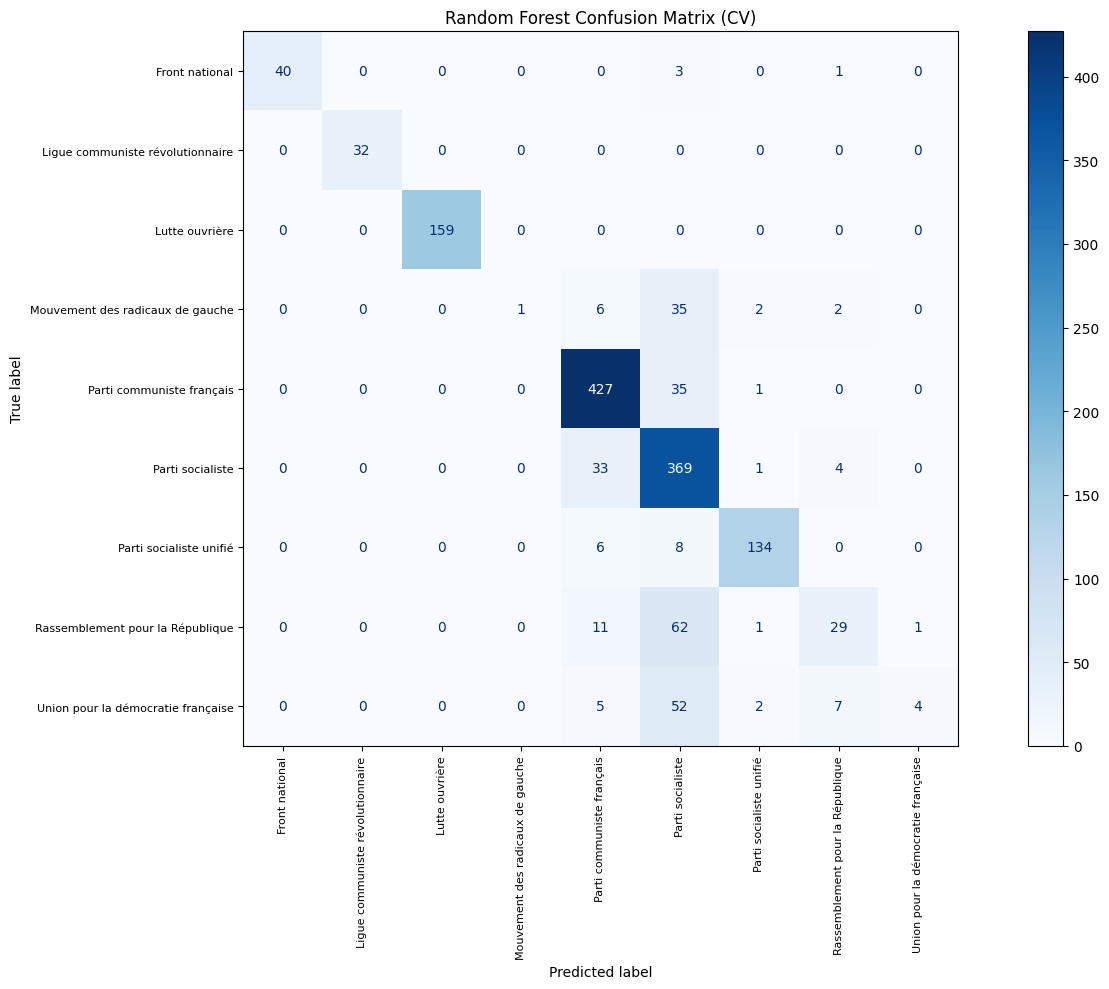

In [35]:
# ##############Train and evaluate a Random Forest classifier on CamemBERT embeddings ######################

#  Cross-validation strategy
cv_folds = 5
cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)  # preserve class proportions

# Random Forest hyperparameter grid
param_grid_rf_fine = {
    'n_estimators': [500, 750, 1000],       # more trees for stability
    'max_depth': [None, 15, 25, 35],       # control overfitting / tree complexity
    'min_samples_split': [2, 5, 10],       # minimum samples to split a node
    'min_samples_leaf': [1, 2, 4],         # minimum samples per leaf to avoid overfitting
    'max_features': ['sqrt', 'log2']       # number of features considered at each split
}

#  Initialize model 
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')

#  GridSearchCV
grid_rf = GridSearchCV(rf_model, param_grid, scoring='f1_weighted', cv=cv, n_jobs=-1, verbose=1)
grid_rf.fit(X, y)

best_rf = grid_rf.best_estimator_
print(f"✅ Best RF hyperparameters: {grid_rf.best_params_}, F1 (CV): {grid_rf.best_score_:.4f}")

# Cross-validated predictions for evaluation
y_pred_rf = cross_val_predict(best_rf, X, y, cv=cv)

print("\n--- RANDOM FOREST CLASSIFICATION REPORT ---")
print(classification_report(y, y_pred_rf))

#  Confusion Matrix in color 
fig, ax = plt.subplots(figsize=(15,10))
ConfusionMatrixDisplay.from_predictions(
    y, y_pred_rf, 
    cmap='Blues',      # color map
    ax=ax
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
plt.title("Random Forest Confusion Matrix (CV)")
plt.tight_layout()
plt.show()


In [30]:
################## Train and evaluate a linear SVM on CamemBERT embeddings ###############

# SVM hyperparameter grid
param_grid_svm_fine = {
    'C': [1.0, 10.0, 50.0, 100.0],      # regularization strength
    'kernel': ['linear', 'rbf'],        # linear or non-linear kernel
    'gamma': ['scale', 'auto']          # only used for rbf kernel
}

#  Initialization SVM model
svm_model = SVC(kernel='linear', probability=True, random_state=42, class_weight='balanced')

# GridSearchCV with stratified CV 
grid_svm = GridSearchCV(svm_model, param_grid_svm, scoring='f1_weighted', cv=cv, n_jobs=-1, verbose=1)
grid_svm.fit(X, y)

best_svm = grid_svm.best_estimator_
print(f"✅ Best SVM hyperparameters: {grid_svm.best_params_}, F1 (CV): {grid_svm.best_score_:.4f}")

# Cross-validated predictions for evaluation 
y_pred_svm = cross_val_predict(best_svm, X, y, cv=cv)

print("\n--- SVM CLASSIFICATION REPORT ---")
print(classification_report(y, y_pred_svm))



Fitting 5 folds for each of 3 candidates, totalling 15 fits
✅ Best SVM hyperparameters: {'C': 10.0}, F1 (CV): 0.8925

--- SVM CLASSIFICATION REPORT ---
                                    precision    recall  f1-score   support

                    Front national       0.98      0.93      0.95        44
  Ligue communiste révolutionnaire       1.00      1.00      1.00        32
                    Lutte ouvrière       1.00      1.00      1.00       159
  Mouvement des radicaux de gauche       0.70      0.67      0.69        46
         Parti communiste français       0.97      0.96      0.97       463
                  Parti socialiste       0.87      0.91      0.89       407
           Parti socialiste unifié       0.98      0.95      0.96       148
  Rassemblement pour la République       0.60      0.62      0.61       104
Union pour la démocratie française       0.53      0.47      0.50        70

                          accuracy                           0.89      1473
          

In [21]:
%pip install lime

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 84.3 MB/s  0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283913 sha256=1b7f2b63e8bf81c410913dcab4cbd93523f458ef1903001f6f5deeeb3f912b42
  Stored in directory: /home/onyxia/.cache/pip/wheels/7c/04/5c/157dc9106512a6c7a30653ec064490c94a49e0fc8f63d19ab9
Successfully built lime
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [lime]3/5 [scikit-image]
Note: you may need to restart the kernel to use updated packages.


In [23]:
from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=np.unique(y))

# On définit une fonction qui fait le pont entre texte brut et prédiction
def predict_proba_pipeline(texts):
    # 1. Obtenir les embeddings CamemBERT pour ces nouveaux textes
    # (Réutilisez votre fonction get_embeddings ici)
    new_features = get_embeddings(texts) 
    # 2. Prédire avec le Random Forest
    return rf_model.predict_proba(new_features)

# Expliquer un manifeste spécifique (ex: le 10ème du dataset)
idx = 10
exp = explainer.explain_instance(df_final.iloc[idx]['text_content'], 
                                 predict_proba_pipeline, 
                                 num_features=10)
exp.show_in_notebook()

 37%|███▋      | 116/313 [03:33<06:03,  1.84s/it]


KeyboardInterrupt: 

Visualisation par Parti
On utilise seaborn pour colorer les points selon les étiquettes politiques

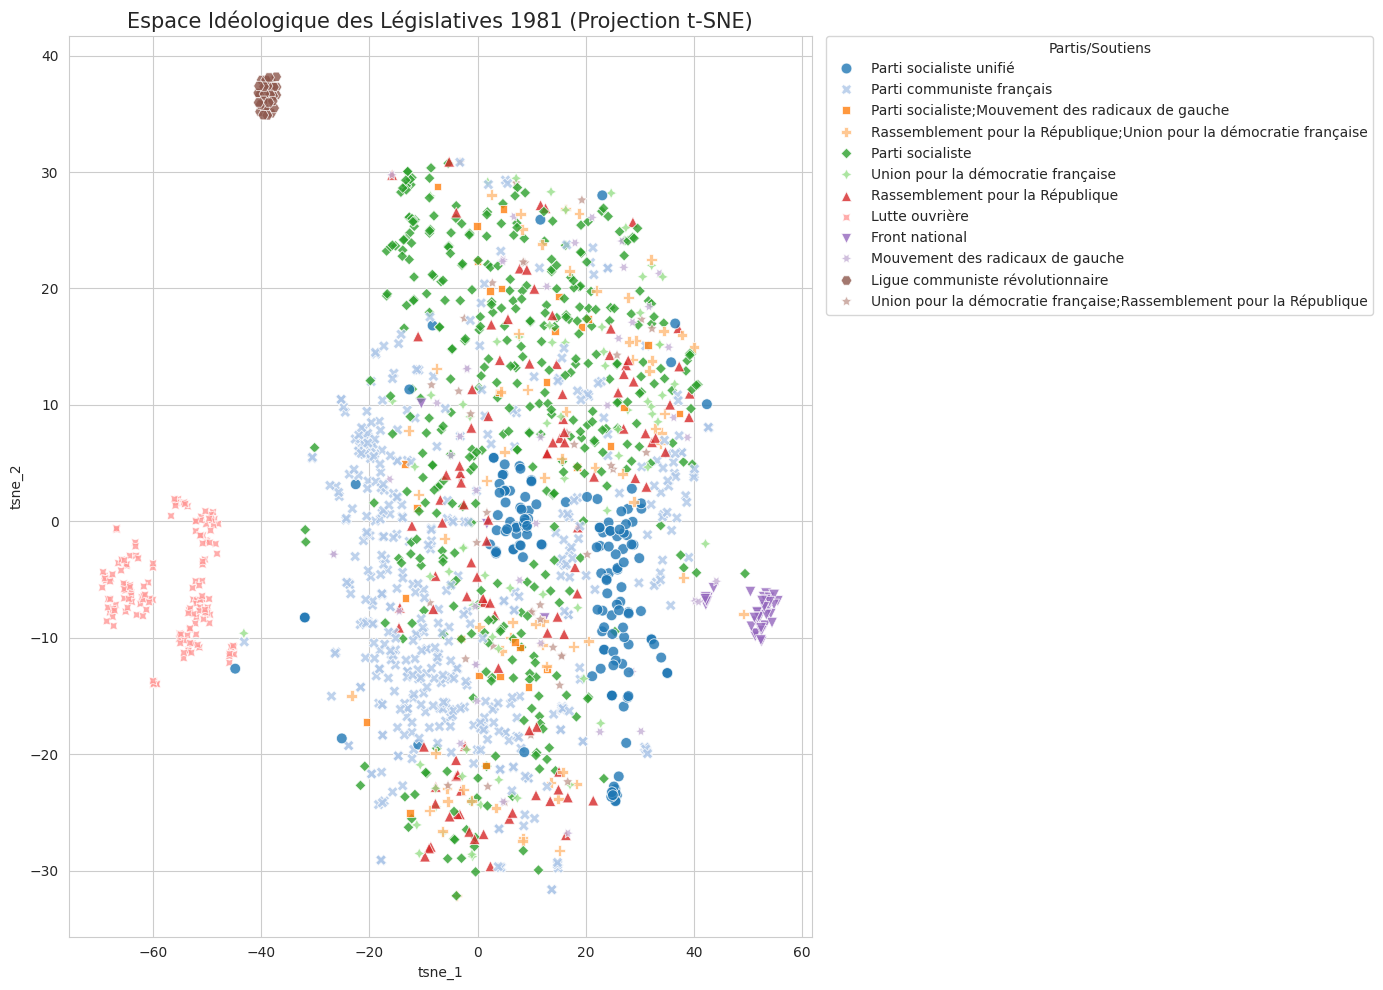

In [28]:
# 1. Définir un dictionnaire de couleurs (à adapter selon tes noms de partis exacts)
custom_palette = {
    'PS': '#E400D0',        # Rose
    'RPR': '#0055A4',       # Bleu soutenu
    'UDF': '#00BFFF',       # Bleu clair
    'PCF': '#FF0000',       # Rouge
    'Ecologiste': '#00FF00', # Vert
    'FN': '#000033',        # Bleu nuit
    # Ajoute les autres ou laisse Seaborn gérer le reste
}

# 2. Améliorer le rendu visuel
plt.figure(figsize=(14, 10))
sns.set_style("whitegrid") # Fond propre pour mieux voir les points

plot = sns.scatterplot(
    data=df_final, 
    x='tsne_1', 
    y='tsne_2', 
    hue='titulaire-soutien', 
    palette='tab20',      # 'tab20' offre plus de distinction que 'viridis'
    style='titulaire-soutien', # Change aussi la forme du point pour aider la lecture
    alpha=0.8, 
    edgecolor='w', 
    s=60                  # Taille des points augmentée
)

plt.title("Espace Idéologique des Législatives 1981 (Projection t-SNE)", fontsize=15)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title="Partis/Soutiens")
plt.tight_layout()
plt.show()

On voit que la prédiction est mauvaise.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd

# 1. Calcul de la matrice de similarité cosinus (facultatif pour PCA/t-SNE mais utile pour analyse)
sim_matrix = cosine_similarity(X)

# 2. PCA pour réduire à 2 dimensions (pour la visualisation)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# 3. t-SNE (souvent plus parlant pour le texte)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X)

# Ajouter les résultats au DataFrame pour faciliter le tracé
df_final['pca_1'], df_final['pca_2'] = X_pca[:, 0], X_pca[:, 1]
df_final['tsne_1'], df_final['tsne_2'] = X_tsne[:, 0], X_tsne[:, 1]

. Les pôles idéologiques isolés (Les "Outliers" par nature)
Certains groupes sont très loin du nuage central. Cela signifie que leur vocabulaire et leurs thématiques sont radicalement différents du reste de la classe politique :

Ligue Communiste Révolutionnaire (Brun, en haut à gauche) : Ils forment un bloc extrêmement compact et isolé. Leur langage est très spécifique (trotskisme), ce qui les rend "uniques" pour CamemBERT.

Lutte Ouvrière (Rose, à gauche) : On observe deux petits sous-groupes. Comme la LCR, leur lexique est très homogène, ce qui crée ce cluster bien séparé des partis de gouvernement.

Front National (Violet, à droite) : En 1981, le FN est encore marginal. Sa position isolée à droite montre que ses thématiques (immigration, sécurité) ne sont pas encore partagées ou formulées de la même manière par la droite classique (RPR/UDF).

2. Le "Cœur de la mêlée" : La bataille pour le centre
Le grand nuage central est là où se joue l'élection. C'est ici que l'interprétation devient subtile :

Le chevauchement PS (Vert) / RPR (Rouge) / UDF (Vert clair) : On remarque que ces points sont très mélangés au centre.

Interprétation : En 1981, même si les idées s'opposent, le format des manifestes et le socle républicain (institutions, gestion locale, économie) utilisent un vocabulaire commun.

Le t-SNE montre que la frontière sémantique entre un "gaulliste social" et un "socialiste modéré" est parfois poreuse.

Le Parti Communiste Français (Bleu clair, croix) : Il est très étalé. On le retrouve beaucoup sur la gauche du nuage central, mais il s'étend aussi vers le bas. Cela reflète la double identité du PCF en 1981 : un discours très idéologique national et des ancrages très locaux.

3. La distance au centre (L'homogénéité du discours)
Les groupes compacts : Regardez les petits cercles bleus foncés (Parti Socialiste Unifié). Ils sont assez proches les uns des autres, ce qui suggère un "prêt-à-penser" ou une ligne éditoriale très stricte pour leurs manifestes.

La dispersion du RPR et de l'UDF : Leurs points (triangles rouges et losanges verts clairs) sont partout. Cela montre une grande variété de discours, probablement parce que les candidats locaux adaptaient énormément leur texte à leur circonscription.

Identifier les Outliers (Erreurs à forte confiance)
L'idée est de comparer la prédiction du modèle avec la réalité. Un "outlier" ici est un texte classé "A" par le modèle avec une probabilité de 90%, alors qu'il appartient au parti "B".

In [30]:
# Obtenir les probabilités de prédiction
probs = rf_model.predict_proba(X)
preds = rf_model.predict(X)

# On cherche les cas où :
# 1. La prédiction est fausse
# 2. La probabilité de la prédiction est très élevée (ex > 0.8)
df_final['prediction'] = preds
df_final['confiance'] = np.max(probs, axis=1)

outliers = df_final[(df_final['prediction'] != df_final['titulaire-soutien']) & (df_final['confiance'] > 0.8)]

print(f"Nombre d'outliers critiques : {len(outliers)}")
display(outliers[['text_content', 'titulaire-soutien', 'prediction', 'confiance']].head())

Nombre d'outliers critiques : 0


,text_content,titulaire-soutien,prediction,confiance


1. Identifier les points "égarés" (Outliers de position)
Pour identifier mathématiquement un point rouge perdu chez les verts, on utilise les coordonnées t-SNE. On définit une zone de "contamination" ou on cherche les points dont les voisins les plus proches appartiennent à un autre parti.

In [37]:
from sklearn.neighbors import KNeighborsClassifier

# On utilise les coordonnées t-SNE comme base spatiale
coords = df_final[['tsne_1', 'tsne_2']].values
labels = df_final['titulaire-soutien'].values

# On entraîne un classifieur de voisinage (K-NN)
# Si k=10, il regarde les 10 points les plus proches sur la carte
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(coords, labels)

# On prédit le parti "géographique"
df_final['parti_geographique'] = knn.predict(coords)

# Un point est "égaré" si son étiquette réelle est différente de ses voisins
outliers_geo = df_final[df_final['titulaire-soutien'] != df_final['parti_geographique']]

# Filtrer pour voir spécifiquement les RPR chez les PS
rpr_chez_ps = outliers_geo[
    (outliers_geo['titulaire-soutien'] == 'Rassemblement pour la République') & 
    (outliers_geo['parti_geographique'] == 'Parti socialiste')
]

print(f"Nombre de candidats RPR parlant comme le PS : {len(rpr_chez_ps)}")
display(rpr_chez_ps[['text_content', 'titulaire-soutien']].head())

Nombre de candidats RPR parlant comme le PS : 43


,text_content,titulaire-soutien
9,REPUBLIQUE FRANÇAISE - TROISIEME CIRCONSCRIPTI...,Rassemblement pour la République
15,1re CIRCONSCRIPTION DE L'AISNE\nÉLECTIONS LÉGI...,Rassemblement pour la République
19,Sciences Po / fonds CEVIPOF\nELECTIONS LEGISLA...,Rassemblement pour la République
97,Sciences Po / fonds CEVIPOF\nELECTIONS LEGISLA...,Rassemblement pour la République
299,"ELECTIONS LEGISLATIVES DE JUIN 1981 - 1"" Circo...",Rassemblement pour la République


In [38]:
# Créer une colonne simplifiée pour la lisibilité
def regrouper_partis(label):
    if 'socialiste' in label.lower() or 'radicaux de gauche' in label.lower():
        return 'Bloc de Gauche'
    if 'République' in label or 'démocratie française' in label:
        return 'Bloc de Droite'
    if 'communiste' in label.lower() and 'révolutionnaire' not in label.lower():
        return 'PCF'
    if 'Lutte ouvrière' in label or 'Ligue communiste' in label:
        return 'Extrême Gauche'
    return 'Autres'

df_final['bloc_politique'] = df_final['titulaire-soutien'].apply(regrouper_partis)

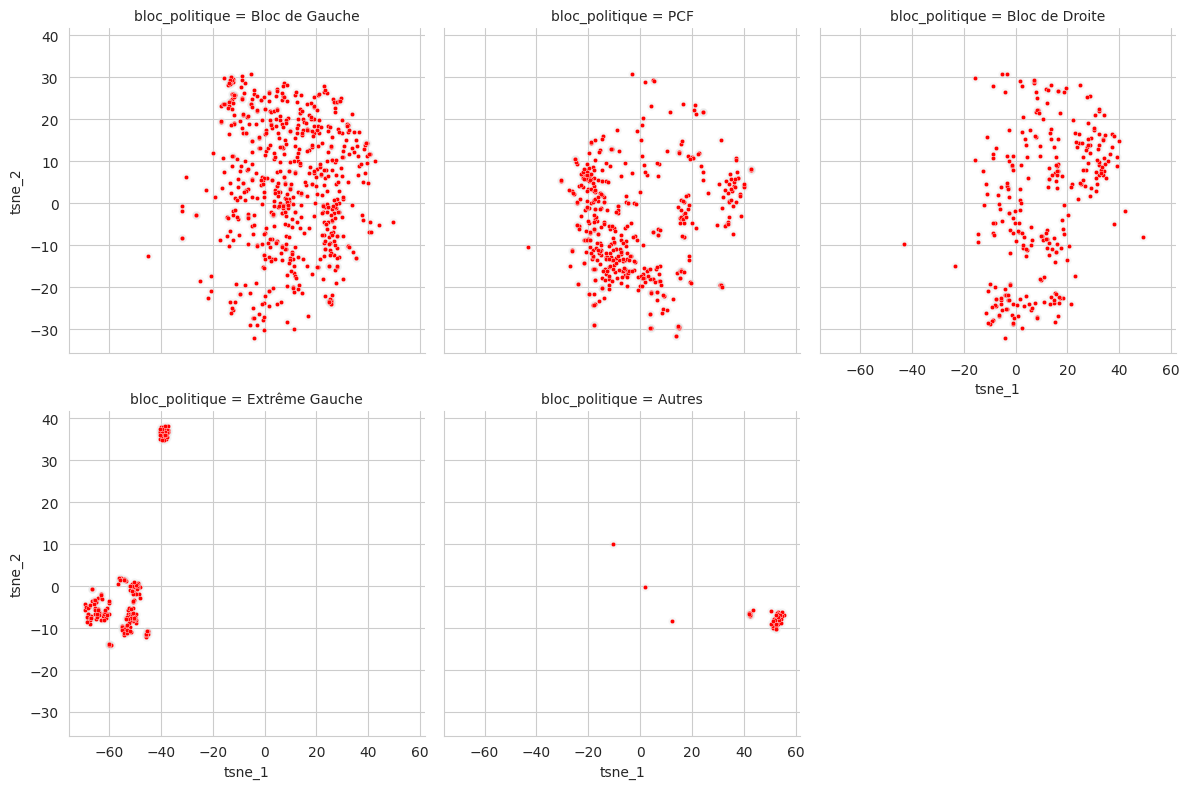

In [ ]:
#On isole les points chauds Cela permet de voir immédiatement si le "Bloc de Gauche" occupe un espace cohérent ou s'il est dispersé.
g = sns.FacetGrid(df_final, col="bloc_politique", col_wrap=3, height=4)
# On trace tous les points en gris en fond
g.map(sns.scatterplot, "tsne_1", "tsne_2", color="lightgrey", alpha=0.2)
# On surligne les points du parti spécifique en couleur
g.map(sns.scatterplot, "tsne_1", "tsne_2", color="red", s=10)

In [41]:
import plotly.express as px

fig = px.scatter(
    df_final, x='tsne_1', y='tsne_2', 
    color='bloc_politique',  # Utilisez la version simplifiée !
    hover_name='titulaire-soutien', # Affiche le nom précis au survol
    opacity=0.6,
    title="Carte Sémantique 1981 - Version Lisible"
)
fig.update_traces(marker=dict(size=5))
fig.show()

Calculer les Centroïdes (Centres de gravité)
Le centroïde est la moyenne de toutes les coordonnées des points d'un groupe. En reliant celui du PS et celui du RPR, on trace l'axe de tension principal de 1981.

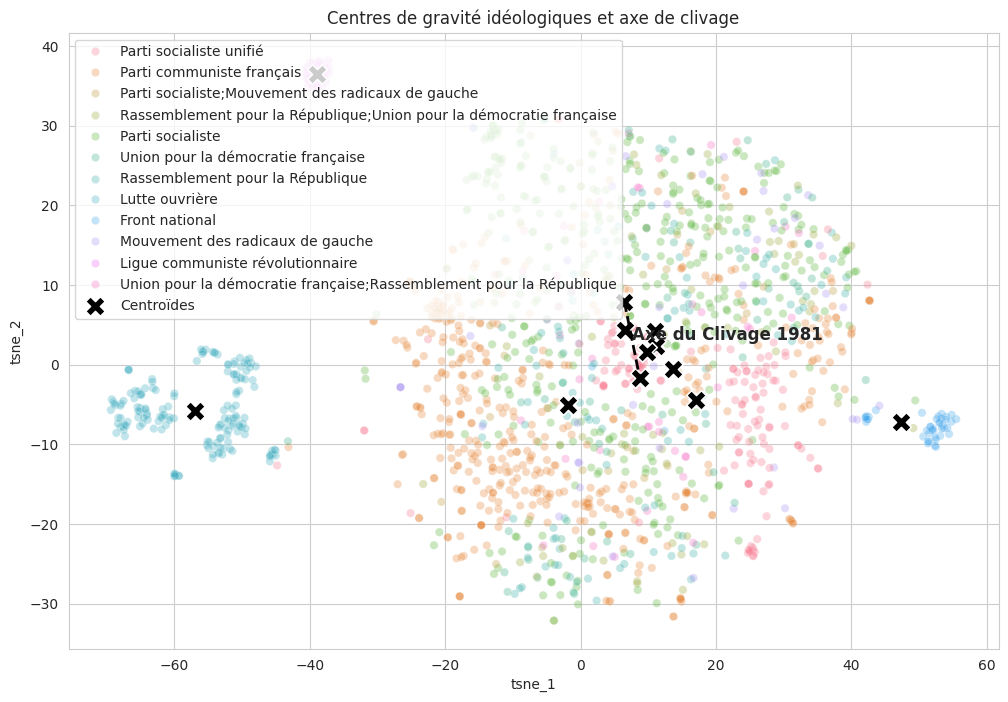

In [39]:
# Calcul du centre de gravité pour chaque parti sur la carte t-SNE
centroids = df_final.groupby('titulaire-soutien')[['tsne_1', 'tsne_2']].mean().reset_index()

# Visualisation avec les lignes de clivage
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_final, x='tsne_1', y='tsne_2', hue='titulaire-soutien', alpha=0.3) # Fond atténué

# Tracer les centres de gravité
sns.scatterplot(data=centroids, x='tsne_1', y='tsne_2', color='black', marker='X', s=200, label='Centroïdes')

# Optionnel : Tracer une ligne entre PS et RPR
ps_center = centroids[centroids['titulaire-soutien'] == 'Parti socialiste'][['tsne_1', 'tsne_2']].values[0]
rpr_center = centroids[centroids['titulaire-soutien'] == 'Rassemblement pour la République'][['tsne_1', 'tsne_2']].values[0]

plt.plot([ps_center[0], rpr_center[0]], [ps_center[1], rpr_center[1]], color='black', linestyle='--', linewidth=2)
plt.text((ps_center[0]+rpr_center[0])/2, (ps_center[1]+rpr_center[1])/2, "Axe du Clivage 1981", fontsize=12, fontweight='bold')

plt.title("Centres de gravité idéologiques et axe de clivage")
plt.show()

Les 5 points les plus "centraux" (Le consensus de 1981)Le "centre du monde" politique sur votre carte correspond au point $(0,0)$ ou à la moyenne globale de tous les manifestes. Ce sont les textes qui utilisent le vocabulaire le plus standard et le moins clivant.

In [36]:
from scipy.spatial.distance import cdist

# Calculer le centre moyen de TOUS les points
centre_global = coords.mean(axis=0).reshape(1, -1)

# Calculer la distance de chaque texte à ce centre
df_final['distance_au_centre_global'] = cdist(coords, centre_global).flatten()

# Extraire les 5 textes les plus proches du centre
consensus_1981 = df_final.nsmallest(5, 'distance_au_centre_global')

print("--- LES 5 TEXTES LES PLUS CONSENSUELS / CENTRAUX ---")
for i, row in consensus_1981.iterrows():
    print(f"\nParti : {row['titulaire-soutien']}")
    print(f"Extrait : {row['text_content'][:300]}...")

--- LES 5 TEXTES LES PLUS CONSENSUELS / CENTRAUX ---

Parti : Parti socialiste
Extrait : Sciences Po / fonds CEVIPOF
Raymond FABRE 52 ans
Sous-Directeur de Collège Conseiller Municipal de Mende
Candidat du PARTI SOCIALISTE
Xavier CHAPUISAT 34 ans
Chercheur au Centre National de la Recherche Scientifique Conseiller Municipal de Saint-André-de-Lancize
Candidat suppléant
NOTRE POLITIQUE LO...

Parti : Parti socialiste
Extrait : Liberté - Égalité · Fraternité
République Française
ELECTIONS LEGISLATIVES de JUIN 1981
3me Circonscription du Gard
PARTI SOCIALISTE
JEAN STEC
CANDIDAT TITULAIRE
JOSETTE BONNEFOY CANDIDAT SUPPLÉANT
Electrices, Electeurs,
Après l'élection de François MITTERRAND à la Présidence de la République, le ch...

Parti : Parti communiste français
Extrait : Département de la MANCHE
5ème Circonscription
Jean-Claude FORAFO Maire-Adjoint de Cherbourg
Elections Législatives du 14 Juin 1981
Candidat pour la Majorité d'Union de la Gauche, présenté par le parti Communiste Français
M

Distance au centre du Cluster (Le "Cœur" idéologique)
Pour chaque parti, on calcule son point moyen (centroïde) et on mesure qui s'en éloigne.

In [32]:
from scipy.spatial.distance import cdist

dist_info = []

for parti in df_final['titulaire-soutien'].unique():
    # Sélectionner les vecteurs du parti
    mask = df_final['titulaire-soutien'] == parti
    points_parti = X[mask]
    
    # Calculer le centre (moyenne des vecteurs)
    centre = points_parti.mean(axis=0).reshape(1, -1)
    
    # Calculer la distance de chaque point au centre
    distances = cdist(points_parti, centre, metric='cosine').flatten()
    
    # Stocker pour analyse
    df_final.loc[mask, 'distance_au_centre'] = distances

# Les manifestes avec la plus petite distance sont les "échantillons purs" du parti
# Les manifestes avec la plus grande distance sont les "marginaux" du parti

Pourquoi c'est puissant pour ton analyse ?
Le Centre : Tu identifies le "manifeste type" du PS ou du RPR en 1981 (celui qui a la distance_au_centre la plus faible).

Les Outliers : Si un manifeste de droite est classé à gauche avec 90% de confiance, c'est peut-être une erreur d'archivage ou un candidat qui a utilisé une rhétorique très spécifique (ex: gaullisme social).

PCA vs t-SNE : Le PCA te montrera peut-être un axe Gauche/Droite très clair (Axe 1), alors que le t-SNE te montrera si les "Radicaux de Gauche" sont vraiment un groupe à part ou s'ils sont noyés dans le PS.

pca

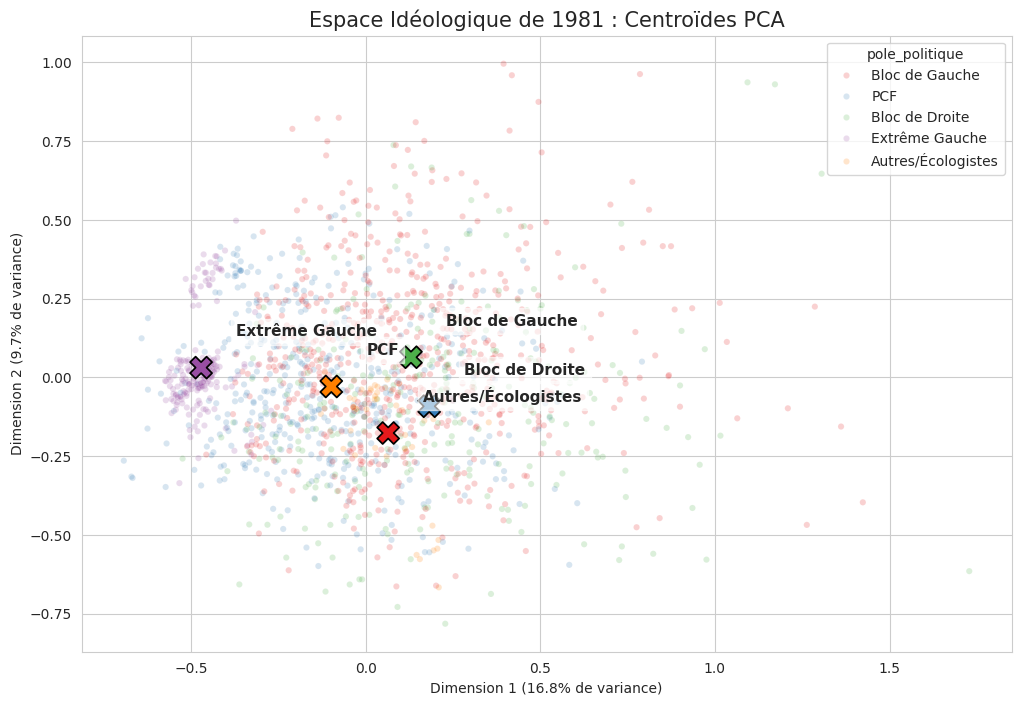

In [43]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# --- ÉTAPE 1 : RECRÉATION SÉCURISÉE DE LA COLONNE ---
def simplifier_81(label):
    label = str(label).lower()
    if 'communiste' in label and 'révolutionnaire' not in label:
        return 'PCF'
    if 'socialiste' in label or 'radicaux de gauche' in label or 'psu' in label:
        return 'Bloc de Gauche'
    if 'république' in label or 'démocratie française' in label:
        return 'Bloc de Droite'
    if 'lutte ouvrière' in label or 'ligue communiste' in label:
        return 'Extrême Gauche'
    return 'Autres/Écologistes'

# On vérifie le nom de votre colonne de labels d'origine (on teste les deux variantes)
col_label_origine = 'titulaire-soutien' if 'titulaire-soutien' in df_final.columns else 'titulaire-support'

df_final['pole_politique'] = df_final[col_label_origine].apply(simplifier_81)

# --- ÉTAPE 2 : CALCUL DU PCA ---
pca = PCA(n_components=2)
# Assurez-vous que X est bien votre matrice d'embeddings CamemBERT
X_pca = pca.fit_transform(X)
df_final['pca_1'] = X_pca[:, 0]
df_final['pca_2'] = X_pca[:, 1]

# --- ÉTAPE 3 : CALCUL DES CENTROÏDES ---
# On calcule la moyenne des coordonnées PCA pour chaque pôle
centroids_pca = df_final.groupby('pole_politique')[['pca_1', 'pca_2']].mean().reset_index()

# --- ÉTAPE 4 : VISUALISATION ---
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# 1. Les points individuels (en fond)
sns.scatterplot(data=df_final, x='pca_1', y='pca_2', hue='pole_politique', 
                palette='Set1', alpha=0.2, s=20)

# 2. Les centres de gravité (les "X")
sns.scatterplot(data=centroids_pca, x='pca_1', y='pca_2', hue='pole_politique', 
                palette='Set1', s=250, marker='X', edgecolor='black', legend=False)

# 3. Ajout des noms des pôles sur le graphique
for i, row in centroids_pca.iterrows():
    plt.text(row['pca_1'] + 0.1, row['pca_2'] + 0.1, row['pole_politique'], 
             fontsize=11, fontweight='bold', bbox=dict(facecolor='white', alpha=0.6))

plt.title("Espace Idéologique de 1981 : Centroïdes PCA", fontsize=15)
plt.xlabel(f"Dimension 1 ({pca.explained_variance_ratio_[0]:.1%} de variance)")
plt.ylabel(f"Dimension 2 ({pca.explained_variance_ratio_[1]:.1%} de variance)")
plt.show()

. Comment interpréter ce tableau ?
Score proche de 1 : Les deux pôles utilisent quasiment le même vocabulaire et les mêmes structures de phrases (ex: PS et PCF en 1981).

Score plus faible : Indique une rupture lexicale. Par exemple, si l'Extrême Droite a une similarité faible avec tous les autres, cela prouve qu'elle introduisait des thématiques (ou un ton) totalement absentes du "consensus" de l'époque.

Souhaitez-vous que j'ajoute à ce code une fonction pour identifie

In [45]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

# On récupère les pôles uniques
poles = df_final['pole_politique'].unique()
resultats_sim = []

for p in poles:
    # 1. Extraction des vecteurs du pôle A
    mask_a = df_final['pole_politique'] == p
    vecteurs_a = X[mask_a]
    
    # --- SIMILARITÉ INTRA-PARTI ---
    # On calcule la similarité de chaque texte du pôle avec tous les autres du même pôle
    sim_intra = cosine_similarity(vecteurs_a)
    # On ne prend que le triangle supérieur (sans la diagonale de 1.0) pour la moyenne
    mask_tri = np.triu_indices(sim_intra.shape[0], k=1)
    moyenne_intra = sim_intra[mask_tri].mean()
    
    # --- SIMILARITÉ INTER-PARTIS ---
    for p_target in poles:
        if p != p_target:
            mask_b = df_final['pole_politique'] == p_target
            vecteurs_b = X[mask_b]
            
            # Similarité entre tous les textes du pôle A et tous ceux du pôle B
            sim_inter = cosine_similarity(vecteurs_a, vecteurs_b)
            moyenne_inter = sim_inter.mean()
            
            resultats_sim.append({
                'Pôle Source': p,
                'Pôle Cible': p_target,
                'Type': 'Inter',
                'Similarité Moyenne': moyenne_inter
            })
    
    # Ajouter la mesure Intra au tableau
    resultats_sim.append({
        'Pôle Source': p,
        'Pôle Cible': p,
        'Type': 'Intra (Cohésion)',
        'Similarité Moyenne': moyenne_intra
    })

df_sim_final = pd.DataFrame(resultats_sim)

C'est la suite logique et la plus rigoureuse pour votre étude. En calculant les moyennes de similarité intra-parti et inter-partis, vous mesurez mathématiquement deux concepts politiques clés :

La Cohésion (Intra) : Est-ce que les candidats d'un même parti parlent tous d'une seule voix (discipline de camp) ou sont-ils dispersés ?

La Porosité (Inter) : À quel point le discours d'un bloc "déborde" sur l'autre ?

Voici le code pour extraire ces métriques à partir de la similarité cosinus :

/tmp/ipykernel_59758/2677827780.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




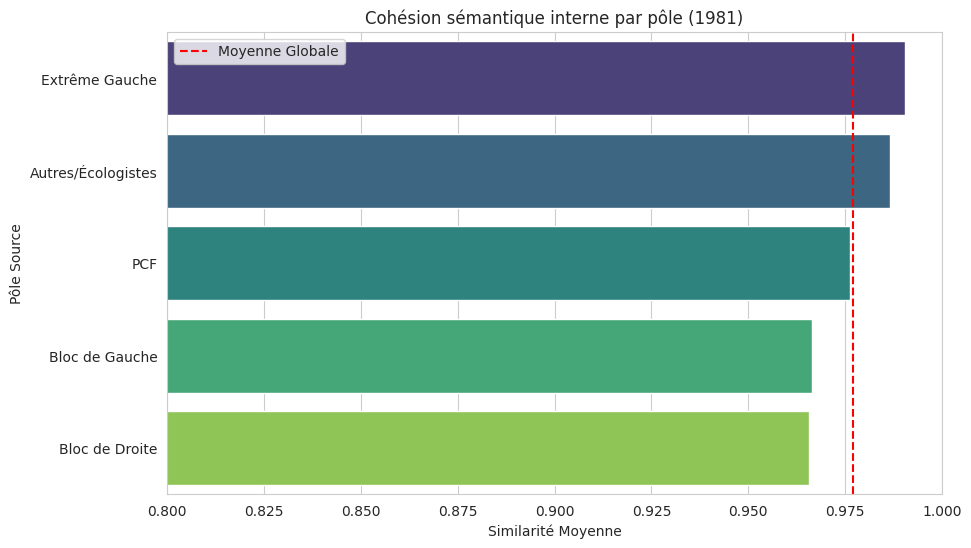

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrer uniquement les scores Intra
df_intra = df_sim_final[df_sim_final['Type'] == 'Intra (Cohésion)'].sort_values('Similarité Moyenne', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_intra, x='Similarité Moyenne', y='Pôle Source', palette='viridis')
plt.title("Cohésion sémantique interne par pôle (1981)")
plt.xlim(0.8, 1.0) # On zoome car les scores sont souvent élevés avec BERT
plt.axvline(df_intra['Similarité Moyenne'].mean(), color='red', linestyle='--', label='Moyenne Globale')
plt.legend()
plt.show()

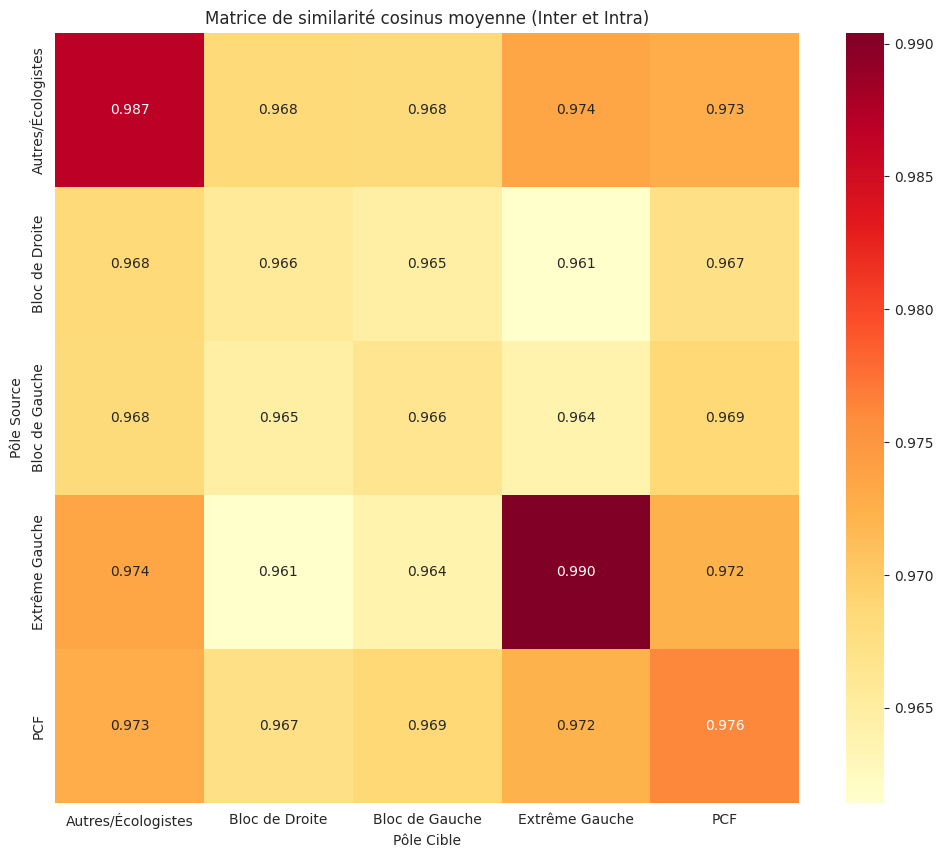

In [47]:
# Pivoter les données pour créer une matrice
matrix_inter = df_sim_final.pivot(index='Pôle Source', columns='Pôle Cible', values='Similarité Moyenne')

plt.figure(figsize=(12, 10))
sns.heatmap(matrix_inter, annot=True, fmt=".3f", cmap="YlOrRd")
plt.title("Matrice de similarité cosinus moyenne (Inter et Intra)")
plt.show()

Comment interpréter vos résultats pour 1981 ?
Si l'Intra-parti est élevé (ex: PCF ou Extrême Gauche) : Cela démontre une langue de bois ou une idéologie très codifiée. Les candidats reprennent mot pour mot les consignes nationales.

Si l'Intra-parti est faible (ex: Bloc de Droite ou de Gauche) : Cela montre une diversité de courants ou une forte adaptation locale des discours. Les candidats "brodent" autour du programme.

Si l'Inter-parti PS / RPR est élevé : Cela prouve que le clivage se joue sur des nuances ou des valeurs, mais que le socle de gestion (les sujets abordés : chômage, prix, sécurité) est identique.

Comparaison des blocs : Regardez si la similarité PS -> PCF est plus forte que RPR -> UDF. Cela vous dira quel camp était le plus uni sémantiquement lors de cette élection historique.

1. L'Outlier de Classification (Erreur de "Logique")
C'est ce que nous avons fait avec le Random Forest et les probabilités (confiance > 0.8).

Définition : Le modèle prédit "Parti A" avec une certitude absolue, mais l'étiquette réelle est "Parti B".

Interprétation : C'est une anomalie textuelle. Soit le candidat a "trahi" son camp en utilisant le vocabulaire de l'adversaire, soit il y a une erreur d'étiquetage dans vos données.

Utilité : Identifier les discours de rupture ou les candidats atypiques (ex: un candidat de droite très social).

2. L'Outlier de Distance (Anomalie de "Position")
C'est ce que nous avons fait avec le calcul de la distance_au_centre (ou distance au centroïde).

Définition : Le texte est très éloigné du "cœur" statistique de son propre parti.

Interprétation : C'est une anomalie de style ou de thématique. Le texte ne ressemble à aucun autre dans son camp, sans pour autant ressembler forcément à l'adversaire. Il est simplement "marginal".

Utilité : Identifier les manifestes qui traitent de sujets très spécifiques, locaux, ou dont le ton est unique.

Comment combiner les deux pour une analyse "Expert" ?
Pour finaliser votre identification, vous pouvez croiser ces deux critères pour trouver les "Vrais Dissidents" de 1981 : ceux qui sont loin de leur centre ET que le modèle classe ailleurs.

Python
# 1. On combine les critères
# On cherche ceux qui sont loin de leur centre ET mal classés
dissidents = df_final[
    (df_final['distance_au_centre_global'] > df_final['distance_au_centre_global'].quantile(0.75)) & 
    (df_final['prediction'] != df_final['pole_politique'])
]

print(f"Nombre de 'dissidents sémantiques' identifiés : {len(dissidents)}")

# 2. Visualisation des dissidents sur le PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_final, x='pca_1', y='pca_2', hue='pole_politique', alpha=0.3)
sns.scatterplot(data=dissidents, x='pca_1', y='pca_2', color='black', marker='o', s=100, label='Dissidents')
plt.title("Localisation des dissidents sémantiques (Loin du centre + Mal classés)")
plt.show()
Ce qu'il vous reste à faire (en application) :
Si vous voulez vraiment boucler l'identification, il serait intéressant de regarder la "Similarité Cosinus par rapport au Centroïde adverse".

Si un candidat RPR a une similarité cosinus plus élevée avec le centroïde PS qu'avec son propre centroïde RPR, alors vous tenez mathématiquement un cas de "mimétisme politique".